###  MicroGrad demo

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from simplegrad import Tensor, Parameter, Sequential, Linear

%matplotlib inline

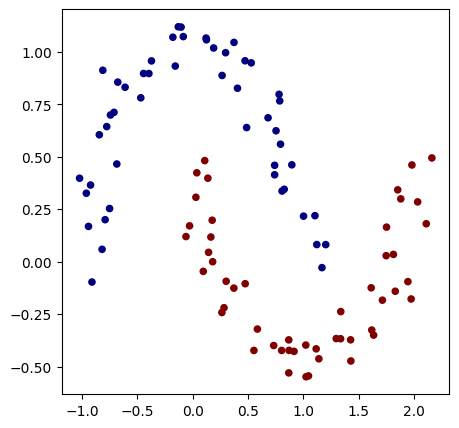

In [2]:
# make up a dataset
np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons, make_blobs
x_np, y_np = make_moons(n_samples=100, noise=0.1)

y_np = y_np*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(x_np[:,0], x_np[:,1], c=y_np, s=20, cmap='jet')

In [4]:
sizes = [2, 16, 16, 1]
model = Sequential([
    Linear(in_size, out_size, activation='relu' if i != len(sizes)-2 else None, no_init=True) 
            for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:]))])
model

Sequential(
   Linear(2 -> 16, activation=relu),
   Linear(16 -> 16, activation=relu),
   Linear(16 -> 1, activation=None)
)

In [6]:
def loss(model):

    formatted_y = Parameter(Tensor(y_np).unsqueeze(-1).unsqueeze(-1), _op='yb')
    inputs = Parameter(Tensor.stack([Tensor(xrow).unsqueeze(-1) for xrow in x_np], dim=0), _op='xb')
    scores = model(inputs)

    hinge_loss_parameter = (1 + -formatted_y * scores).relu() / formatted_y.shape[0]
    data_loss = hinge_loss_parameter.sum()

    alpha = 1e-4
    reg_loss = alpha * sum([(p*p).sum() for p in model.parameters()])
    print(f'data_loss, {data_loss.data.data}, reg_loss: {reg_loss.data.data}')
    total_loss = data_loss + reg_loss

    correct = sum(y_np == (scores.data.reshape(scores.data.shape[0]) > 0).astype(int).data)
    return total_loss, int(100*correct / len(y_np))


total_loss, accuracy = loss(model)
print(f'total_loss: {total_loss.data.data}')
print(f'accuracy: {accuracy}%')

data_loss, 12.240156610877056, reg_loss: 0.03232551055371796
total_loss: 12.272482121430775
accuracy: 0%


In [32]:
# optimization


for k in range(100):
    
    # forward
    total_loss, acc = loss(model)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc}%")

data_loss, 13.119351844989724, reg_loss: 0.030441702123464535
step 0 loss NumpyTensor(13.14979354711319), accuracy 50%
data_loss, 8.376204875468627, reg_loss: 3.0362668772008106
step 1 loss NumpyTensor(11.412471752669438), accuracy 50%
data_loss, 4.227396818346339, reg_loss: 3.0312107075583437
step 2 loss NumpyTensor(7.258607525904683), accuracy 50%
data_loss, 1.4769810685105171, reg_loss: 3.028664657747006
step 3 loss NumpyTensor(4.505645726257523), accuracy 50%
data_loss, 0.8210955704535474, reg_loss: 3.027146536430355
step 4 loss NumpyTensor(3.8482421068839026), accuracy 50%
data_loss, 0.5483478836341308, reg_loss: 3.0256894418511306
step 5 loss NumpyTensor(3.5740373254852615), accuracy 50%
data_loss, 0.3413864751266843, reg_loss: 3.0243590522354267
step 6 loss NumpyTensor(3.365745527362111), accuracy 50%
data_loss, 0.18610254281999358, reg_loss: 3.023138653560166
step 7 loss NumpyTensor(3.2092411963801593), accuracy 50%
data_loss, 0.09105382389078141, reg_loss: 3.022001106191967
st

In [33]:
formatted_y = Parameter(Tensor(y_np).unsqueeze(-1).unsqueeze(-1), _op='yb')
inputs = Parameter(Tensor.stack([Tensor(xrow).unsqueeze(-1) for xrow in x_np], dim=0), _op='xb')
scores = model(inputs)
scores.data.data[:5]

array([[[-8.84280742]],

       [[-1.69601423]],

       [[31.76094733]],

       [[-1.93365342]],

       [[25.82870902]]])

In [37]:
for layer in model.layers:
    print(layer.w.data.data.mean(), layer.b.data.data.mean())


0.12987927693390436 0.523264675613479
0.08249331895215267 -0.04108641139705491
0.2654706651133918 1.3075678202330638


(-1.548639298268643, 1.951360701731357)

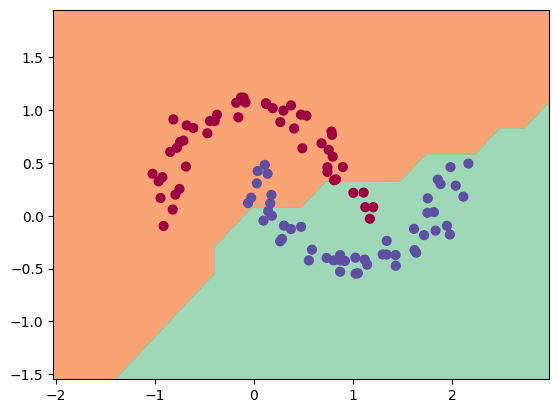

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
#TODO: Transfer the net into my code.
#TODO: Create gif of decision boundary shifting over time.